In [70]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wnm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
df = pd.read_csv('./spam.csv')
df.sample(5)

,spam,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
4978,ham,Spending new years with my brother and his fam...,NaN,NaN,NaN
1893,ham,Good Morning plz call me sir,NaN,NaN,NaN
4545,ham,Never try alone to take the weight of a tear t...,NaN,NaN,NaN
4862,spam,Bored housewives! Chat n date now! 0871750.77....,NaN,NaN,NaN
4806,spam,PRIVATE! Your 2004 Account Statement for 07849...,NaN,NaN,NaN


In [72]:
df['spam'] = np.where(df['spam'] == 'spam', 1, 0)

In [73]:
df.sample(3)

,spam,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
1283,0,Yes i thought so. Thanks.,NaN,NaN,NaN
4101,0,Ok then i will come to ur home after half an hour,NaN,NaN,NaN
1254,0,What your plan for pongal?,NaN,NaN,NaN


In [74]:
df = df[['spam', 'message']]

In [75]:
df

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will М_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [76]:
def clean_text(text: str):
    text = text.lower()
    # Удаление спец символов
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Удаление множественных пробелов
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\n', '')
    # Фильтрация стоп слов
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [word for word in text.split(" ") if not word in stop_words]
    return ' '.join(filtered_sentence)
    #return text

In [77]:
df['message'][1]

'Ok lar... Joking wif u oni...'

In [78]:
clean_text(df['message'][1])

'ok lar joking wif u oni'

In [79]:
df['message'] = df['message'].apply(clean_text)

In [80]:
df.sample(3)

,spam,message
1064,0,thats fine ill bitch later
3278,0,solve case man found murdered ltdecimalgt ltgt...
605,0,take care n get well soon


In [81]:
counts = df['spam'].value_counts()
spam_perc = round((counts[1] / df.shape[0]) * 100, 2)
print(f'Spam letters: {spam_perc}%, Normal letters {abs(100 - spam_perc)}%')

Spam letters: 13.41%, Normal letters 86.59%


In [82]:
counts

spam
0    4825
1     747
Name: count, dtype: int64

#### Делаю кол-во спам писем == не спаму (747 спам писем)

In [83]:
non_spam_sampled = df[df['spam'] == 0].sample(n=747, replace=False)
balanced_df = pd.concat([non_spam_sampled, df[df['spam'] == 1]])
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
print(balanced_df['spam'].value_counts())

spam
0    747
1    747
Name: count, dtype: int64


In [84]:
#df = df.sample(frac=1) # Несбалансированная база
df = balanced_df.sample(frac=1) # Сбалансированная база спам == не спам
valid_size = 1000 # Размер валидационной выборки
x_train = df[0:-valid_size]
x_valid = df[-valid_size:df.shape[0]]

In [85]:
spam_prob = {}
non_spam_prob = {}
total_word_count = 0

def calc_word_probs(dtfr):
    global spam_prob, non_spam_prob, total_word_count
    
    spam: pd.DataFrame = dtfr[dtfr['spam'] == 1]
    non_spam: pd.DataFrame = dtfr[dtfr['spam'] == 0]
    
    spam_word_count = 0
    non_spam_word_count = 0

    # Count occurrences in spam
    for _, row in spam.iterrows():
        for word in row['message'].split():
            if word == '': continue
            spam_prob[word] = spam_prob.get(word, {'cnt': 0, 'val': 0})
            spam_prob[word]['cnt'] += 1
            spam_word_count += 1

    # Count occurrences in non-spam
    for _, row in non_spam.iterrows():
        for word in row['message'].split():
            if word == '': continue
            non_spam_prob[word] = non_spam_prob.get(word, {'cnt': 0, 'val': 0})
            non_spam_prob[word]['cnt'] += 1
            non_spam_word_count += 1

    total_word_count = spam_word_count + non_spam_word_count

    # Apply smoothing and calculate probabilities
    all_words = set(spam_prob.keys()).union(set(non_spam_prob.keys()))
    for word in all_words:
        if word not in spam_prob:
            spam_prob[word] = {'cnt': 0, 'val': 0}
        if word not in non_spam_prob:
            non_spam_prob[word] = {'cnt': 0, 'val': 0}

        # Apply Laplace smoothing
        spam_prob[word]['val'] = (spam_prob[word]['cnt'] + 1) / (spam_word_count + len(all_words))
        non_spam_prob[word]['val'] = (non_spam_prob[word]['cnt'] + 1) / (non_spam_word_count + len(all_words))
calc_word_probs(x_train)

In [86]:
def print_top_10(table: dict):
    item_list = [(word, data) for word, data in table.items()]
    sorted_spam_prob = sorted(item_list, key=lambda x: x[1]['val'], reverse=True)
    top_10_spam_words = sorted_spam_prob[:10]

    for word, data in top_10_spam_words:
        print(f"Word: '{word}' Count: {data['cnt']}, Value: {data['val']}")

In [87]:
print_top_10(spam_prob)

Word: 'call' Count: 133, Value: 0.020389531345100426
Word: 'free' Count: 79, Value: 0.012172854534388313
Word: '2' Count: 53, Value: 0.008216676810712111
Word: 'ur' Count: 49, Value: 0.007608034083992696
Word: 'mobile' Count: 48, Value: 0.007455873402312843
Word: 'text' Count: 45, Value: 0.00699939135727328
Word: 'txt' Count: 44, Value: 0.006847230675593427
Word: '4' Count: 44, Value: 0.006847230675593427
Word: 'u' Count: 40, Value: 0.006238587948874011
Word: 'reply' Count: 34, Value: 0.0053256238587948874


In [88]:
print_top_10(non_spam_prob)

Word: 'u' Count: 43, Value: 0.010392064241851677
Word: 'im' Count: 28, Value: 0.00684931506849315
Word: 'dont' Count: 15, Value: 0.003778932451582428
Word: 'know' Count: 15, Value: 0.003778932451582428
Word: 'come' Count: 14, Value: 0.0035427491733585263
Word: 'ok' Count: 14, Value: 0.0035427491733585263
Word: 'get' Count: 14, Value: 0.0035427491733585263
Word: 'call' Count: 14, Value: 0.0035427491733585263
Word: 'want' Count: 13, Value: 0.0033065658951346244
Word: 'go' Count: 11, Value: 0.002834199338686821


#### Вычисляю вероятность спама для 1 слова

In [89]:
test_word = "free"
P_SPAM = spam_prob[test_word]['val']
P_NOT_SPAM = (1 - spam_prob[test_word]['val'])

P_S = P_SPAM/(P_NOT_SPAM + P_SPAM)
P_S

0.012172854534388313

#### Вычисление вероятности спамовости предложения по формуле из лекции

In [90]:
def bayes_calc(sentence: str):
    clean_sent = clean_text(sentence)
    p_spam = 1 # произведение вероятностей спама слова F_i
    p_non_spam = 1 # произведение вероятностей не спама слова F_i
    p_word_given_spam = 0.5 # prior probability of spam
    p_word_given_non_spam = 0.5 # prior probability of non-spam
    
    for word in clean_sent.split():
        if word == '': continue
        
        if word in spam_prob:
            p_word_given_spam = spam_prob[word]['val']
        else:
            # Apply smoothing for unseen words
            p_word_given_spam = 1 / (sum(spam_prob[word]['cnt'] for word in spam_prob) + len(spam_prob))
        
        if word in non_spam_prob:
            p_word_given_non_spam = non_spam_prob[word]['val']
        else:
            # Apply smoothing for unseen words
            p_word_given_non_spam = 1 / (sum(non_spam_prob[word]['cnt'] for word in non_spam_prob) + len(non_spam_prob))

        p_spam *= p_word_given_spam
        p_non_spam *= p_word_given_non_spam

    # Calculate the posterior probability P(Spam|Sentence)
    p_spam_sentence = p_spam
    p_non_spam_sentence = p_non_spam
    
    return p_spam_sentence / (p_spam_sentence + p_non_spam_sentence)


In [91]:
bayes_calc("Good day everyone, the meeting is going to be today at 5 am") 

0.012134990138148912

In [92]:
bayes_calc("get free money get credit from out company")

0.6405115436929815

In [93]:
threshold = 0.5
def is_spam(sent):
    return 1 if bayes_calc(sent) > threshold else 0

In [94]:
is_spam("get free money get credit from out company")

1

In [95]:
is_spam("Good day everyone, the meeting is going to be today at 5 am")

0

In [96]:
is_spam("call free to ur txt") # Топ спам слова

1

In [97]:
right = 0 
error = 0
valid_size = len(x_valid)
for _, row in x_valid.iterrows():
    y_pred = is_spam(row['message'])
    y_true = row['spam'] 
    right += y_true == y_pred
    error += y_true != y_pred

In [98]:
right

930

In [99]:
error

70

In [100]:
valid_size

1000

#### Тестирование и метрики

In [101]:
print(f"Correct: {round(right/valid_size*100, 2)}% Errors: {round(error/valid_size*100, 2)}%")

Correct: 93.0% Errors: 7.0%


In [102]:
bayes_calc("free call get credit")

0.9937376183880186

In [103]:
bayes_calc("hey bro how are you? how is your day? Meeting today")

0.0030734570819407514

In [104]:
bayes_calc("Hi, the coffe is free today in our school cafeteria")

0.13956601490372264

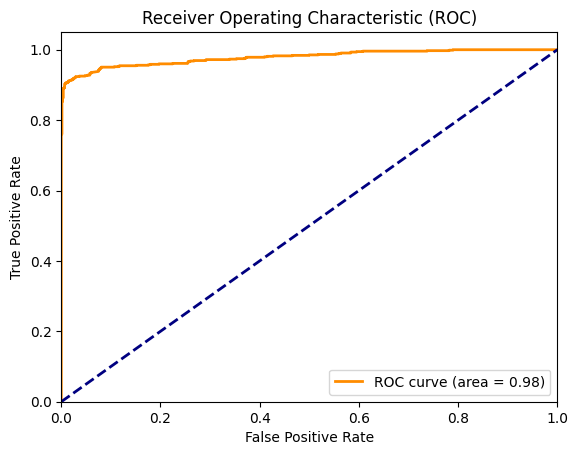

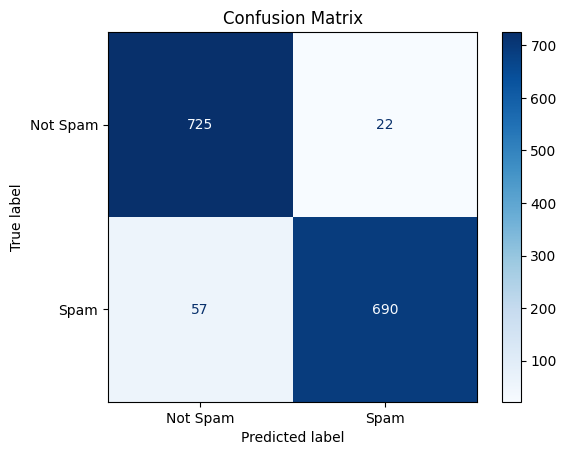

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

# Проходим по датафрейму и делаем предсказания
for _, row in df.iterrows():
    y_pred.append(is_spam(row['message']))
    y_true.append(row['spam'])

# Преобразование списков в numpy массивы
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Расчет метрик
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, [bayes_calc(msg) for msg in df['message']])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Построение матрицы неточностей
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()